# Convolutional Neural Nets for image classification

# Background

Here we will implement _transfer learning_.
We are addressing the task of classifying small images into classes (10 of them), _using (most of) a neural network that was trained on 1000 classes_. $1000 \neq 10$; that's why this is transfer learning! We will replace the 1000-class classifier part of that model with a 10-class classifier and keep the rest of the model unmodified.

What are the ten classes? Here they are:

![mnist](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)

Lots of little bitty images - each one is 28x28 pixels; each pixel is a single gray-scale value.

We will learn how to import a trained neural network model from the PyTorch **Model Zoo**, discard the "classification head" of the model (preserving the convolutional early stages), add a new "classification head", and train it to do a good job.

In [ ]:
import torch
import torchvision
import torchsummary
import os
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import random

1. Here's a flag named `verbose` that you can set to control how much verbosity is present in the output.

2. Also here is a way to set a `device` variable. If you're running on a Colab instance with a GPU (try it! see below), `device` will be `cuda` (and training will run way way faster); otherwise, `device` will be `cpu`.

In [ ]:
verbose = True

device = "cuda" if torch.cuda.is_available() else "cpu"
if verbose: print(f"We're running on the {device}.")

We're running on the cuda.


# ResNet18

TL;DR: We create an instance of the `torchvision.models.resnet18` model. It's named `resnet18`. We print its layout out if we're in verbose mode.


The ResNet family of models are convolutional neural networks that have been used for various visual processing tasks.

Here's the arXiv article about ResNet: https://arxiv.org/abs/1512.03385

We're using the "shallowest" ResNet model here (ResNet18) because we don't have a lot of data to fine tune it.

Luckily for us (?), PyTorch's `torchvision` library has a "Model Zoo" with many models in it; we can get just a model and train it ourselves, or get a pretrained model with weights optimized for an interesting task. We'll do the latter. When you run this the first time, a download will be triggered to get the model (44.7 MBytes) into your runtime.

 This ResNet was trained for visual object classification – it takes small square color images of an appropriate size and classifies them as belonging to one of 1000 different classes. Follow this link to get a look at the different classes used to train ResNet: https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

More info (including sample code!) on ResNet here: https://pytorch.org/hub/pytorch_vision_resnet/

After loading the model, we print the instance for a terse summary of the architecture.

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
if verbose: print(f'The ResNet18 model looks like this:\n{resnet18}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


The ResNet18 model looks like this:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

That text summary gives some hints on accessing parts of the model. Some layers have nested descriptions, and you can follow the nesting in the instance using more dots in the slot name. If an integer like `(0)` starts a line, you use it as an index. Thus, your code can access layers like this: `resnet18.fc`, `resnet18.layer1`, `resnet18.layer3[1].conv2`, `resnet18.layer4[0].downsample[0]`, and so on. By using these names, you can change the architecture of the resnet by writing to the slot for the part you want to change.

Graphical depiction of ResNet18:
![resnet18](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*OkpgHpmqDuor9FKay8_9hQ.png)

You should be able to correspond the convolutional layers in the text summary to the blocks in the figure.

The weird loopy connections that jump over layers are the "Res" part of Resnet; they convert the block of layers into a "Residual" block which has certain advantages.

# 1. Replacing the classification head

TL;DR: Replace the resnet18 model's `fc` slot with a new `Linear` layer with 10 output nodes.

We can view the ResNet model as having two parts:
 + a "backbone" that generates a feature vector by repeated convolutions, maxpooling, etc.  In goes an image, out comes a vector that we can treat as a pattern to be classified.
 + a fully-connected classification network (aka a "classification head") that takes the feature vector and performs classification.

The ResNet18 pre-trained model we instantiated was trained on 1000 classes. We can tell by looking at the final classification layer (also known as the "classification head" - it has 1000 neurons, one per class. It was printed above (if we're verbose); let's print it again here. Pay attention to the number of inputs and outputs.

In [ ]:
print(f'Resnet fc layer: {resnet18.fc}')

Resnet fc layer: Linear(in_features=512, out_features=1000, bias=True)


`resnet18.fc` is a slot in an object and it is assignable. If you assign `resnet18.fc` to some other thing, that thing is assumed to be a layer that has the correct number of inputs and replaces the 1000-node `Linear` layer that's present by default.

Replace the default FC layer with a `Linear` layer with `resnet18.fc.in_features` inputs and 10 outputs.  Then print `resnet18.fc` again to verufy that your change to the `fc` layer was made.


In [ ]:
# Replace the default FC layer with a new Linear layer
resnet18.fc = torch.nn.Linear(in_features=resnet18.fc.in_features, out_features=10)

# Verify the change
print(f"Updated ResNet18 fc layer: {resnet18.fc}")

Updated ResNet18 fc layer: Linear(in_features=512, out_features=10, bias=True)


# 2. GPUize if possible

If we have a GPU, we should use it. In order to use it, we have to move the model to it, and when we're training and testing it, we need to move the data to it. `.to()` is the method that does this.  You move a model named `foo` to a device `device` with the idiom `foo = foo.to(device)`. Similarly, you move a tensor to the device using something like `x = x.to(device)`. If `device` is `cpu`, this will work (it won't do anything, but it won't throw an error).

In [ ]:
# Move the ResNet18 model to the specified device (either "cuda" or "cpu")
resnet18 = resnet18.to(device)

# Verify the device
print(f"ResNet18 model moved to {device}.")

ResNet18 model moved to cuda.


# 3. Report

`torchsummary.summary(model,size)` will print out a table of parameters and output tensor shapes by layer, along with a summary. Run `torchsummary.summary()` on the network with a size of `(3, 32,32)` (three channels per pixel; 32x32 pixels in the image) to determine how many parameters are present in the ResNet18 model. Based on that number and the "params size" in megabytes, how many bytes are occupied by each parameter?

In [ ]:
# Three channels (RGB) and 32x32 pixels
input_size = (3, 32, 32)
torchsummary.summary(resnet18, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Param Size in Megabytes: 44.59 megabytes.

Number of Parameters: 11,689,512 parameters.

Bytes per Parameter:
$$ \frac{44.59 \text{MB}}{11,689,512} $$

Each parameter in the ResNet18 model occupies approximately 3.81453 bytes.

# 4. Freeze the backbone; train only the new classification head

TL;DR: use the idioms below to freeze all parameters in the model and then unfreeze the parameters in the FC layer you just created.

It's commonly assumed (with decent justification through experiments) that the popular image-classification backbines like ResNet, VGG, etc. generate good generic feature vectors that can discriminate between lots of different things in the input images. We're going to exploit that by agreeing with the assumption and tuning only a fully-connected layer, operating on the 512-dimensional feature vector produced by the backbone, to discriminate between the classes in this 10- lass problem. We're going to **freeze** the backbone part of the model, which will cause training to run faster because the parameters in the convolutional layers won't be trained.

The idiom to freeze everything in a net is:

```
for param in resnet18.parameters():
    param.requires_grad = False
```

Now that code will freeze **all** of the parameters including those of the fc layer we replaced above. We don't want to be frozen, so we'll have to unfreeze them.  Luckily, the parameters for individual parts (layers) of a model can be accessed using the instance variables we discussed above.

```
for param in resnet18.fc.parameters():
    param.requires_grad = True
````

Doing this to ResNet18 net below.

In [ ]:
# Freeze
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze
for param in resnet18.fc.parameters():
    param.requires_grad = True

## Data

We're using a labeled data set called MNIST that contains a bunch of small, grayscale, 28x28 images of handprinted digits, 0 through 9. The digit value is the class number; all images of '4' are class 4, _etc._

The MNIST data set is pre-partitioned into training and testing sets. We'll train the net on training data, in mini-batches provided by a `DataLoader`. The fiddly details are not of interest in this assignment (and there are plenty of online tutorials on them) so this code is provided for free.

When you run this the first time in a session, the data will be downloaded to your runtime.

In [ ]:
# Set up the training data.

# First, get the data set - the first time this is done in a fresh runtime, it will trigger a download.

# The pipeline of transforms takes the images, converts them to PyTorch tensors,
# normalizes them to zero mean and unit standard deviation, resizes them to 32x32,
# and converts them from grayscale (1-channel) to color (3-channel) with red=green=blue
train_dataset = torchvision.datasets.MNIST('./mnist/', train=True, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                               torchvision.transforms.Resize((32,32)),
                                               torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                                               ])
                                           )

# Now, wrap the dataset in a DataLoader. The DataLoader is an iterable. Each iteration will give us 64
# randomly chosen images.

batch_size_train = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

100%|██████████| 9912422/9912422 [04:55<00:00, 33567.00it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 361321.89it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:48<00:00, 33942.74it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22255290.62it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
# now load the MNIST test data and wrap it in a DataLoader.
#
# batch size is bigger (1000 images at a time) than train_data
#


test_dataset = torchvision.datasets.MNIST('./mnist/', train=False, download=True,
                                          transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                              torchvision.transforms.Resize((32,32)),
                                              torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1))
                                              ])
                                          )

batch_size_test = 1000
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test, shuffle=True)

This code renders a few sample images from the training data set, with the class labels in the title.
The warning message is triggered by the normalization, which I'm too lazy to fix.

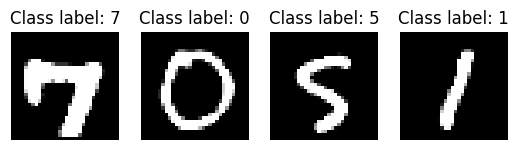

In [ ]:
# plot some images.
l = len(train_dataset)
fig,axs = plt.subplots(nrows=1,ncols=4)
for ax in axs:
    ax.axis('off')
    (x,lab) = train_dataset[random.randint(0,l-1)]
    ax.imshow(x.permute(1,2,0).numpy())
    ax.title.set_text(f'Class label: {lab}')
plt.show()


# 5. Training Setup

Now we write code to support training of the classification head of the model.

a. for the loss, use `torch.nn.CrossEntropyLoss()`

b. for the optimizer, use `torch.optim.SGD()` with your model's parameters, a learning rate of 0.0001, and a momentum of 0.9.

c. add code to move `data` and `label` (obtained from the dataloader) to the `device`.

d. add code to get the output of the network for the input `data`

e. add the one liner to use the calculated loss to trigger calculation of the gradients for the trainable parameters.

In [ ]:
# a. specify loss
loss = torch.nn.CrossEntropyLoss()


# b. specify optimizer
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)


def train_one_epoch(net, train_loader, optimizer, loss, epoch_idx):
    net.train()  # Put the net in training mode
    losses = []
    for batch_idx, (data, label) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        # c. Move data and label to device
        data, label = data.to(device), label.to(device)

        # Clear the optimizer's gradient estimate
        optimizer.zero_grad()

        # d. Compute output of net from data
        output = net(data)

        # Compute loss from net output and known labels
        # Loss is an object; use l.item() to get its value
        l = loss(output, label)

        # e. Use the loss to trigger calculation of gradients
        l.backward()

        # Update optimizer state
        optimizer.step()
        losses.append(l.item())

    print(f'Average loss for epoch {epoch_idx}: {np.mean(losses)}')
    return losses

Reset the weights in the fc part of the model so we can train it from scratch

In [ ]:
def reset_fc_weights(m):
    m.fc.reset_parameters()

# 6. Perform Training

Runing the trainer for five epochs.  

This is a short piece of code that does the following:
 + reset the weights using the function above.
 + create an empty list that will hold all of the per-batch, per-epoch losses calculated by `train_one_epoch()`
 + loop 5 times:
  - run train_one_epoch, appending the results to the list
 + as feedback, print out the starting and ending elements of the vector of losses you saved.

Training may take a while, especially on the CPU. Data point: On an L4 GPU, this takes 30 seconds per epoch. CPU will be much slower.

In [ ]:
# Reset weights using the provided function
reset_fc_weights(resnet18)

# Create an empty list to hold losses
epoch_losses = []

# Training loop for 5 epochs
for epoch in range(5):
    losses = train_one_epoch(resnet18, train_dataloader, optimizer, loss, epoch)
    epoch_losses.extend(losses)

# Print starting and ending elements of the losses
print(f"Starting loss: {epoch_losses[0]}")
print(f"Ending loss: {epoch_losses[-1]}")

  0%|          | 0/938 [00:00<?, ?it/s]

Average loss for epoch 0: 2.2144539328272153


  0%|          | 0/938 [00:00<?, ?it/s]

Average loss for epoch 1: 1.1179270439310622


  0%|          | 0/938 [00:00<?, ?it/s]

Average loss for epoch 2: 0.9192601617084128


  0%|          | 0/938 [00:00<?, ?it/s]

Average loss for epoch 3: 0.8210797378185716


  0%|          | 0/938 [00:00<?, ?it/s]

Average loss for epoch 4: 0.7643113058131895
Starting loss: 6.892475128173828
Ending loss: 0.6759588122367859


# 7. Plot the training losses

Plot the contents of the vector of losses you accumulated during training, with a descriptive text in the graph title, x-axis label, and y-axis label.

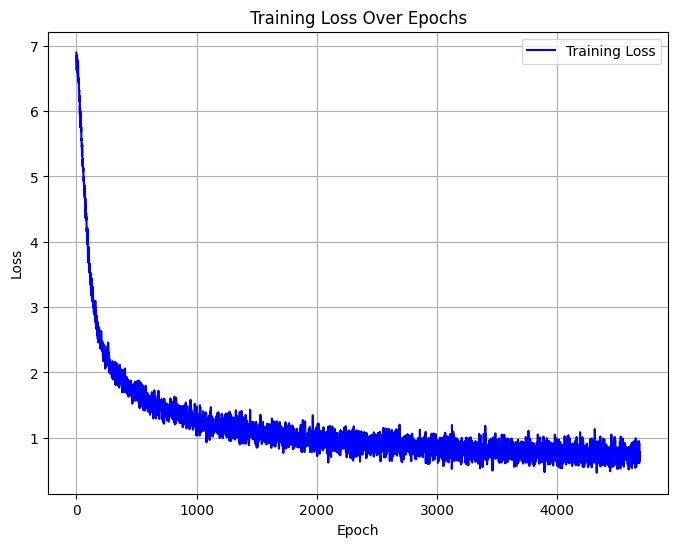

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epoch_losses, label="Training Loss", color="b")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# Evaluating the model on the test data

Here's some code to calculate and report the accuracy of the model.


In [ ]:
def get_accuracy(model=resnet18, loader=test_dataloader,device=device):
    """computes accuracy of the given model on data from the given dataloader.
    Returns accuracy as a nuber between 0 (100% wrong) and 1 (100% right)."""
    model.eval() # put model in evaluation (not training) mode
    all_predicted_labels = []
    all_labels = []
    with torch.no_grad():  # turn off gradient calcs; don't need 'em when doing prediction
        for data, target in loader: # get a batch
            all_labels = all_labels + target.tolist() # keep track of labels
            data = data.to(device) # move data to device and classify it using the model.
            output = model(data) # get output - a list of 10 logits
            # find the index of the largest logit; that's the predicted class number.
            ol = output.tolist()
            output_labs = [np.argmax(x) for x in ol] # get output class number
            all_predicted_labels = all_predicted_labels + output_labs
    # at this point, all_labels has all the ground-truth labels and all_predicted_labels
    # has all of the predicted labels - calculate the accuracy.
    acc = sklearn.metrics.accuracy_score(all_labels, all_predicted_labels)
    return [all_labels, all_predicted_labels,acc]

In [ ]:
[labels,predicted_labels,acc] = get_accuracy()
print(f'Overall Accuracy for {len(labels)} test samples is {acc}')

Overall Accuracy for 10000 test samples is 0.8066


# 8. Accuracy by Class

Use the lists of true and predicted labels computed above to get a _per-class_ accuracy value for the trained model. Printing out those accuracies for each of the ten classes.

We recommend divide-and-conquer. Write a function `accuracy_for_class(class_no,true_labels,predicted_labels)` that calculates the accuracy for a single class `class_no`, and then loop over the possible class values.

What classes did the model perform relatively poorly on? Why do you think it did so.

In [ ]:
def accuracy_for_class(class_no, true_labels, predicted_labels):
    class_mask = np.array(true_labels) == class_no
    class_true_labels = np.array(true_labels)[class_mask]
    class_predicted_labels = np.array(predicted_labels)[class_mask]
    class_accuracy = sklearn.metrics.accuracy_score(class_true_labels, class_predicted_labels)
    return class_accuracy

# Calculate per-class accuracies
all_class_accuracies = []
for class_no in range(10):
    class_accuracy = accuracy_for_class(class_no, labels, predicted_labels)
    all_class_accuracies.append(class_accuracy)
    print(f"Class {class_no}: Accuracy = {class_accuracy:.4f}")

# Overall accuracy
overall_accuracy = sklearn.metrics.accuracy_score(labels, predicted_labels)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

Class 0: Accuracy = 0.8694
Class 1: Accuracy = 0.9656
Class 2: Accuracy = 0.7258
Class 3: Accuracy = 0.7554
Class 4: Accuracy = 0.8299
Class 5: Accuracy = 0.7253
Class 6: Accuracy = 0.8267
Class 7: Accuracy = 0.8084
Class 8: Accuracy = 0.7556
Class 9: Accuracy = 0.7780

Overall Accuracy: 0.8066


The model performs well on simpler digits (1, 4, 6) but struggles with more complex or variable digits (2, 5, 9). Digit 0 has a clear circular shape, making it relatively easy for the model to recognize (86.94%). Digit 1 is the simplest because it is a straight vertical line which contributes to high accuracy (96.56%). The variation in writing styles for digit 2 (e.g., open or closed loops) makes it challenging to classify consistently (72.58%). The curved structure of digit 3 and variations in loop shapes impact accuracy (75.54%). The inverted L shape of digit 4 helps with accurate classification (82.99%). For digit 5, different writing styles result in variations, making classification challenging (72.53%). The curved shape of digit 6 and its distinction from other digits contribute to accuracy (82.67%). The unique diagonal line in digit 7 affects classification, could be classifiying it as 1 instead (80.84%). The complex loops in digit 8 lead to variations in writing styles, so this reduces accuracy (75.56%). The closed loop in digit 9 resembles 6, leading to some misclassifications (77.80%).